In [3]:
!pwd

/content


In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
import pandas as pd


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/MyDrive/Folder/

/content/gdrive/MyDrive/Folder


In [8]:
from PIL import Image
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list()) 
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [9]:
def prep_pipeline2(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('/content/gdrive/MyDrive/Folder/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = '/content/gdrive/MyDrive/Folder/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)

  df = img_np_convert_scaled(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train, y_train = df_to_np2(df_train)
  X_test, y_test = df_to_np2(df_test)
  X_val, y_val = df_to_np2(df_val)
  return (X_train, y_train), (X_test, y_test), (X_val, y_val), weight, labels

In [10]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 4
majority = 6000

train_set, test_set, val_set, class_weight, labels = prep_pipeline2(majority, h, w, aug_targets, aug_count, aug_size)

In [11]:
X_train = train_set[0]
y_train = np.argmax(train_set[1], axis=1)

X_val = val_set[0]
y_val = np.argmax(val_set[1], axis=1)

X_test = test_set[0]
y_test = np.argmax(test_set[1], axis=1)

In [12]:
print(X_train.shape, X_test.shape, X_val.shape)

(6916, 24320) (1397, 24320) (1397, 24320)


In [13]:
class_weight

{0: 18.57079646017699,
 1: 7.441489361702128,
 2: 5.529644268774703,
 3: 50.566265060240966,
 4: 4.260913705583756,
 5: 1.0,
 6: 41.14705882352941}

In [14]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val_std=sc.transform(X_val)

Text(0, 0.5, 'cumulative explained variance')

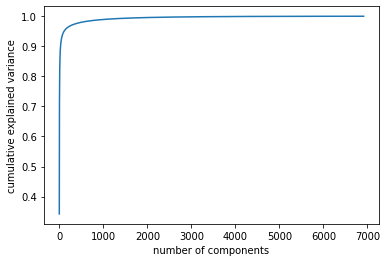

In [16]:
pca = PCA().fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [17]:
print(X_train_std.shape)
print(X_test_std.shape)
print(X_val_std.shape)

(6916, 24320)
(1397, 24320)
(1397, 24320)


In [18]:
pca = PCA(n_components = 0.95).fit(X_train_std)

In [20]:
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_val_pca = pca.transform(X_val_std)

In [24]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

In [25]:
from sklearn.linear_model import RidgeClassifier
reg = RidgeClassifier(class_weight=class_weight)
reg.fit(X_train_pca, y_train)
print(reg.score(X_train_pca, y_train))
print(reg.score(X_val_pca, y_val))
print(reg.score(X_test_pca, y_test))

0.5449681897050318
0.5261274158911954
0.5211166785969935


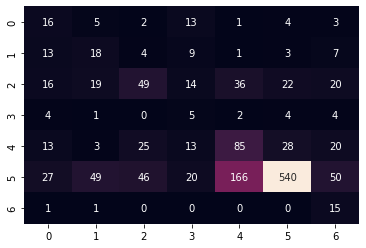

In [27]:
y_pred = reg.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [28]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.18      0.36      0.24        44
         bcc       0.19      0.33      0.24        55
         bkl       0.39      0.28      0.32       176
          df       0.07      0.25      0.11        20
         mel       0.29      0.45      0.36       187
          nv       0.90      0.60      0.72       898
        vasc       0.13      0.88      0.22        17

    accuracy                           0.52      1397
   macro avg       0.31      0.45      0.31      1397
weighted avg       0.68      0.52      0.57      1397



In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight=class_weight)
lr.fit(X_train_pca, y_train)
print(lr.score(X_train_pca, y_train))
print(lr.score(X_val_pca, y_val))
print(lr.score(X_test_pca, y_test))

0.4998554077501446
0.47816750178954903
0.4595561918396564


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


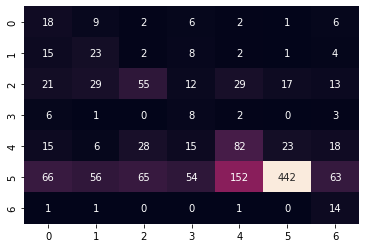

In [31]:
y_pred = lr.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [32]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.13      0.41      0.19        44
         bcc       0.18      0.42      0.26        55
         bkl       0.36      0.31      0.34       176
          df       0.08      0.40      0.13        20
         mel       0.30      0.44      0.36       187
          nv       0.91      0.49      0.64       898
        vasc       0.12      0.82      0.20        17

    accuracy                           0.46      1397
   macro avg       0.30      0.47      0.30      1397
weighted avg       0.69      0.46      0.52      1397



In [33]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', C = 1, class_weight=class_weight)
svc.fit(X_train_pca, y_train)
print(svc.score(X_train_pca, y_train))
print(svc.score(X_val_pca, y_val))
print(svc.score(X_test_pca, y_test))

0.5941295546558705
0.525411596277738
0.5246957766642806


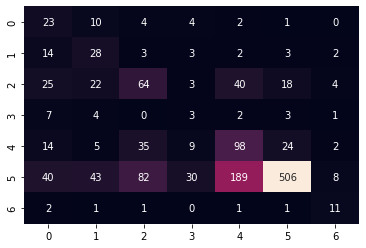

In [34]:
y_pred = svc.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=True)

In [35]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.18      0.52      0.27        44
         bcc       0.25      0.51      0.33        55
         bkl       0.34      0.36      0.35       176
          df       0.06      0.15      0.08        20
         mel       0.29      0.52      0.38       187
          nv       0.91      0.56      0.70       898
        vasc       0.39      0.65      0.49        17

    accuracy                           0.52      1397
   macro avg       0.35      0.47      0.37      1397
weighted avg       0.69      0.52      0.57      1397



In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=6, random_state=0, class_weight=class_weight)
rf.fit(X_train_pca, y_train)
print(rf.score(X_train_pca, y_train))
print(rf.score(X_val_pca, y_val))
print(rf.score(X_test_pca, y_test))

0.6522556390977443
0.5533285612025769
0.5468861846814602


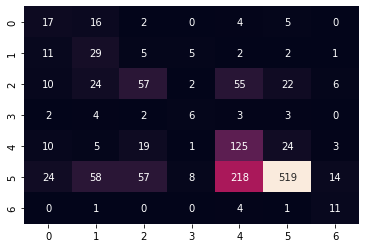

In [37]:
y_pred = rf.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [38]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.23      0.39      0.29        44
         bcc       0.21      0.53      0.30        55
         bkl       0.40      0.32      0.36       176
          df       0.27      0.30      0.29        20
         mel       0.30      0.67      0.42       187
          nv       0.90      0.58      0.70       898
        vasc       0.31      0.65      0.42        17

    accuracy                           0.55      1397
   macro avg       0.38      0.49      0.40      1397
weighted avg       0.69      0.55      0.58      1397

